# Reto de Ingeniería de Datos: Optimización y Visualización
**Diplomado en Estrategias de Datos - USTA**
* **Estudiante:** Paula Ximena Guevara Gomez
* **Fecha:** 3/01/26

**Descripción:** En este cuaderno aplico técnicas de *downcasting*, vectorización y visualización avanzada sobre el dataset de Taxis de NYC 

**Diccionario de Datos (Resumen)**

* id: Identificador único del viaje.

* vendor_id: Proveedor del servicio (1 o 2).

* pickup_datetime: Fecha y hora de inicio.

* passenger_count: Número de pasajeros.

* pickup_longitude / pickup_latitude: Coordenadas de inicio.

* dropoff_longitude / dropoff_latitude: Coordenadas de fin.

* store_and_fwd_flag: Bandera de conexión ('Y'/'N').

* trip_duration: Duración del viaje en segundos (Target).

### Parte A: Reto Pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from pathlib import Path

In [2]:
ruta_datos=Path("..")/"Datos"/"raw"/"train.csv"
df= pd.read_csv(ruta_datos)

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### **Fase 1: Diagnóstico y Memoria (La base del rendimiento)**

**1. Concepto: Inspección Profunda (`memory_usage='deep'`)**

* **Teoría:** `df.info()` miente a veces. El parámetro `'deep'` interroga el uso real de RAM de los objetos (strings).
* **Reto:** Carga el archivo `train.csv`. ¿Cuánta memoria RAM consume exactamente el DataFrame inicial? Compara el resultado con y sin el argumento `deep`.

In [4]:
df.memory_usage(deep="True")

Index                       132
id                     96270504
vendor_id              11669152
pickup_datetime       110856944
dropoff_datetime      110856944
passenger_count        11669152
pickup_longitude       11669152
pickup_latitude        11669152
dropoff_longitude      11669152
dropoff_latitude       11669152
store_and_fwd_flag     84601352
trip_duration          11669152
dtype: int64

In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 461.8 MB


In [6]:
#se gastan 461.8 MB de RAM



**2. Concepto: Downcasting Numérico (`pd.to_numeric`)**

* **Teoría:** `int64` es excesivo para contar pasajeros (máximo 6-9).
* **Reto:** Identifica las columnas `passenger_count` y `vendor_id`. Conviértelas al tipo de entero más pequeño posible (`int8` o `int16`) usando `pd.to_numeric(..., downcast='integer')`. ¿Cuántos MB ahorraste solo con esto?

In [7]:
df['passenger_count']=pd.to_numeric(df['passenger_count'],downcast='integer')

df['vendor_id']=pd.to_numeric(df['vendor_id'],downcast='integer')
df['trip_duration']=pd.to_numeric(df['trip_duration'],downcast='integer')
df['pickup_longitude']=pd.to_numeric(df['pickup_longitude'],downcast='float')
df['pickup_latitude']=pd.to_numeric(df['pickup_latitude'],downcast='float')
df['dropoff_longitude']=pd.to_numeric(df['dropoff_longitude'],downcast='float')
df['dropoff_latitude']=pd.to_numeric(df['dropoff_latitude'],downcast='float')


In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int8   
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int8   
 5   pickup_longitude    1458644 non-null  float32
 6   pickup_latitude     1458644 non-null  float32
 7   dropoff_longitude   1458644 non-null  float32
 8   dropoff_latitude    1458644 non-null  float32
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int32  
dtypes: float32(4), int32(1), int8(2), object(4)
memory usage: 414.5 MB


**3. Concepto: Categoricals (`astype('category')`)**

* **Teoría:** Los strings repetitivos (como 'store_and_fwd_flag') consumen mucha RAM. Categorizarlos guarda índices numéricos.
* **Reto:** Convierte la columna `store_and_fwd_flag` a tipo `category`. Verifica los valores únicos y confirma la reducción de memoria.

---

In [9]:
memoria_antes = df['store_and_fwd_flag'].memory_usage(deep=True) #peso de la columna actualmente
print(f"Memoria original: {memoria_antes / 1024**2:.2f} MB")

df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category') #convertir a categoría store_and_fwd_flag

print("Valores únicos:", df['store_and_fwd_flag'].unique()) #se verifican los valores únicos y la memoria
memoria_despues = df['store_and_fwd_flag'].memory_usage(deep=True)
print(f"Memoria después: {memoria_despues / 1024**2:.2f} MB")

ahorro = (1 - (memoria_despues / memoria_antes)) * 100 #ahorro
print(f"Ahorro de memoria del {ahorro:.2f}%")

Memoria original: 80.68 MB
Valores únicos: ['N', 'Y']
Categories (2, object): ['N', 'Y']
Memoria después: 1.39 MB
Ahorro de memoria del 98.28%


### **Fase 2: Vectorización y Tiempo (Adiós a los bucles)**

**4. Concepto: Datetime Vectorizado (`to_datetime` con formato)**

* **Teoría:** Dejar que Pandas "adivine" el formato es lento. Especificar el `format` acelera la conversión.
* **Reto:** Convierte `pickup_datetime` y `dropoff_datetime` a objetos datetime. Mide el tiempo que tarda especificando `format='%Y-%m-%d %H:%M:%S'` vs no especificarlo.

In [10]:
import time

# SIN formato
start_time = time.time()
pd.to_datetime(df['pickup_datetime'])
pd.to_datetime(df['dropoff_datetime'])
end_time = time.time()
print(f" Tiempo SIN formato: {end_time - start_time:.4f} segundos")

#CON formato 
start_time = time.time()
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
end_time = time.time()
print(f" Tiempo CON formato: {end_time - start_time:.4f} segundos")

 Tiempo SIN formato: 0.3834 segundos
 Tiempo CON formato: 0.3496 segundos



**5. Concepto: Accessors de Fecha (`.dt`)**

* **Teoría:** Extraer partes de una fecha es instantáneo con `.dt`, sin necesidad de lambdas.
* **Reto:** Crea dos nuevas columnas: `hour_of_day` y `day_of_week` usando el accessor `.dt`. ¿Cuál es la hora pico (la hora con más viajes iniciados) en NYC?

In [11]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour #crea las columnas usando .dt
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # 0=Lunes, 6=Domingo

#hora pico
hora_pico = df['hour_of_day'].value_counts().idxmax()
total_viajes_pico = df['hour_of_day'].value_counts().max()

print(f"La hora pico en NYC es: {hora_pico}:00 hrs")
print(f"Cantidad de viajes iniciados a esa hora: {total_viajes_pico:,}")

La hora pico en NYC es: 18:00 hrs
Cantidad de viajes iniciados a esa hora: 90,600





**6. Concepto: Operaciones Vectorizadas Complejas (NumPy)**

* **Teoría:** Usar `np.where` es infinitamente más rápido que `apply` con `if/else`.
* **Reto:** Crea una columna `trip_type`. Si la `trip_duration` es mayor a 3600 segundos (1 hora), etiquétalo como "Largo", de lo contrario "Corto". Hazlo usando `np.where`.

In [12]:
import numpy as np

df['trip_type'] = np.where(df['trip_duration'] > 3600, 'Largo', 'Corto') #clasificacion con np.where
print(df['trip_type'].value_counts()) #resultados

trip_type
Corto    1446327
Largo      12317
Name: count, dtype: int64




**7. Concepto: Matemáticas Geoespaciales (La prueba de fuego)**

* **Teoría:** Calcular distancias con trigonometría (Haversine) usando columnas enteras en lugar de filas.
* **Reto:** Implementa la fórmula de Haversine usando funciones de NumPy (`np.sin`, `np.cos`, `np.sqrt`) para calcular la distancia en Km entre (pickup_lat, pickup_lon) y (dropoff_lat, dropoff_lon). Crea la columna `distance_km`.

---

In [13]:
def calcular_distancia_haversine(df):
    
    r = 6371.0 #Radio de la Tierra en kilómetros

    #convertir grados a radianes con numpy
    lat1, lon1 = np.radians(df['pickup_latitude']), np.radians(df['pickup_longitude'])
    lat2, lon2 = np.radians(df['dropoff_latitude']), np.radians(df['dropoff_longitude'])

    #se calculan las diferencias de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    #fórmula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2 
    c = 2 * np.arcsin(np.sqrt(a))
    
    return r * c


df['distance_km'] = calcular_distancia_haversine(df) #nueva columna
print(df[['distance_km']].describe())#resumen de la columna
df['distance_km'].head()

        distance_km
count  1.458644e+06
mean   3.440864e+00
std    4.296538e+00
min    0.000000e+00
25%    1.231838e+00
50%    2.093705e+00
75%    3.875308e+00
max    1.240909e+03


0    1.498675
1    1.805410
2    6.385065
3    1.485300
4    1.188640
Name: distance_km, dtype: float32

### **Fase 3: Method Chaining y Transformación (Código Elegante)**

**8. Concepto: `.query()**

* **Teoría:** Filtrar con strings es más legible y, en grandes volúmenes, a veces más eficiente que el boolean indexing tradicional.
* **Reto:** Filtra el dataset para quedarte solo con viajes que: tengan más de 1 pasajero, la distancia sea mayor a 0 y menor a 100 km. Todo en una sola línea de `.query()`.

In [14]:
df_filtrado = df.query("passenger_count > 1 and 0 < distance_km < 100") #Filtro

#filas despues del filtro 
print(f"Filas originales: {len(df):,}")
print(f"Filas después del filtro: {len(df_filtrado):,}")

Filas originales: 1,458,644
Filas después del filtro: 423,345



**9. Concepto: `.assign()**

* **Teoría:** Permite crear columnas al vuelo dentro de una cadena sin romper el flujo.
* **Reto:** En un solo bloque encadenado: toma el df filtrado, crea una columna `velocidad_kph` (distancia / (duración/3600)) y ordena los valores por velocidad descendente.


In [15]:
# Encadenamiento de métodos 
df_final = (df_filtrado
    .assign(velocidad_kph = lambda x: x['distance_km'] / (x['trip_duration'] / 3600))
    .sort_values(by='velocidad_kph', ascending=False)
)

print(df_final[['id', 'distance_km', 'trip_duration', 'velocidad_kph']].head()) #primeros resultados

                id  distance_km  trip_duration  velocidad_kph
1001028  id1653963     0.783315              2    1409.967434
1107     id0729156     0.703079              2    1265.542495
1322903  id1389227     1.029990              4     926.990747
1200843  id2579630     0.761070              3     913.283944
693299   id2487275    19.619970            121     583.734654



**10. Concepto: `.clip()` (Manejo de Outliers)**

* **Teoría:** En lugar de borrar filas extremas, a veces queremos "toparlas" a un límite lógico.
* **Reto:** Hay viajes con duraciones absurdas. Usa `.clip()` para limitar la columna `trip_duration` a un máximo de 7200 segundos (2 horas) y un mínimo de 60 segundos. Reemplaza la columna original.

In [16]:
# Aplicar el recorte de valores extremos
df['trip_duration'] = df['trip_duration'].clip(lower=60, upper=7200)

# Verificación rápida
print(f"Duración mínima actual: {df['trip_duration'].min()} segundos")
print(f"Duración máxima actual: {df['trip_duration'].max()} segundos")

Duración mínima actual: 60 segundos
Duración máxima actual: 7200 segundos


**11. Concepto: `.pipe()` (Funciones personalizadas)**

* **Teoría:** Inserta una función defina por el usuario en la cadena.
* **Reto:** Define una función `def etiqueta_trafico(df):` que reciba el dataframe y devuelva solo los viajes ocurridos en "Hora Punta" (ej: 7-9am y 5-7pm). Aplícala usando `.pipe()` al final de tu cadena anterior.

---

In [17]:
def filtrar_hora_punta(df):
    #filtra el dataframe para obtener viajes en horas pico (7-9 AM y 5-7 PM) Usando la columna 'hour_of_day' del Reto 5
    condicion = (
        ((df['hour_of_day'] >= 7) & (df['hour_of_day'] <= 9)) | 
        ((df['hour_of_day'] >= 17) & (df['hour_of_day'] <= 19))
    )
    return df[condicion]

#integra todo con .pipe()
df_final_analisis = (df
    .query("passenger_count > 1 and distance_km > 0")
    .assign(velocidad_kph = lambda x: x['distance_km'] / (x['trip_duration'] / 3600))
    .pipe(filtrar_hora_punta) #función personalizada
    .sort_values('velocidad_kph', ascending=False)
)

print(f"Viajes restantes en Hora Punta: {len(df_final_analisis):,}")
print(df_final_analisis['hour_of_day'].unique())

Viajes restantes en Hora Punta: 123,358
[18  9  7  8 17 19]


### **Fase 4: Agregaciones Avanzadas y Ventanas**

**12. Concepto: `groupby()` con Named Aggregation**

* **Teoría:** La sintaxis moderna permite renombrar columnas al momento de agregar.
* **Reto:** Agrupa por `vendor_id` y calcula: promedio de duración (llámalo `mean_duration`) y total de distancia (llámalo `total_km`). Todo en un solo paso.



In [18]:
# Realizar la agregación nombrada
resumen_proveedores = df.groupby('vendor_id').agg(
    mean_duration = ('trip_duration', 'mean'),
    total_km = ('distance_km', 'sum')
)

# Mostramos el resultado
print(resumen_proveedores)

           mean_duration    total_km
vendor_id                           
1             830.988072  2308734.25
2             859.230843  2710261.25


**13. Concepto: `.transform()` (La magia oculta)**

* **Teoría:** A diferencia de `agg` (que reduce filas), `transform` mantiene el mismo número de filas original. Ideal para comparar "fila vs promedio de su grupo".
* **Reto:** Crea una columna `avg_duration_by_hour`. Cada fila debe tener la duración promedio de *todos los viajes que ocurrieron en esa misma hora*. (Usa `groupby('hour')['duration'].transform('mean')`).



In [19]:
df['avg_duration_by_hour'] = df.groupby('hour_of_day')['trip_duration'].transform('mean') #transform

print(df[['id', 'hour_of_day', 'trip_duration', 'avg_duration_by_hour']].head()) #comparamos un viaje individual contra su promedio de hora

          id  hour_of_day  trip_duration  avg_duration_by_hour
0  id2875421           17            455            939.548723
1  id2377394            0            663            789.825195
2  id3858529           11           2124            882.902506
3  id3504673           19            429            797.947535
4  id2181028           13            435            908.073105


**14. Concepto: Filtrado por Grupos (`filter`)**

* **Teoría:** Filtrar grupos enteros basados en una propiedad del grupo, no de la fila.
* **Reto:** Queremos analizar solo las horas del día que son "activas". Filtra el dataframe para mantener solo los datos de las horas (`hour_of_day`) que tengan más de 10,000 viajes en total.



In [20]:
df_horas_activas = df.groupby('hour_of_day').filter(lambda x: len(x) > 10000) #Filtra grupos (horas)
print(f"Horas originales en el dataset: {df['hour_of_day'].nunique()}")
print(f"Horas activas (con >10k viajes): {df_horas_activas['hour_of_day'].nunique()}")

# Ver qué horas fueron eliminadas (las menos activas)
horas_eliminadas = set(df['hour_of_day'].unique()) - set(df_horas_activas['hour_of_day'].unique())
print(f"Horas descartadas por baja actividad: {horas_eliminadas}")

#todas las horas tienen mas de 10000 viajes

Horas originales en el dataset: 24
Horas activas (con >10k viajes): 24
Horas descartadas por baja actividad: set()


**15. Concepto: `cut` y `qcut` (Binning)**

* **Teoría:** Convertir variables continuas en discretas (rangos).
* **Reto:** Usa `pd.qcut` para dividir la columna `distance_km` en 4 cuartiles: "Muy Corto", "Corto", "Largo", "Muy Largo". ¿Cuál es la duración promedio de los viajes "Muy Largos"?

---

In [21]:
#crea los bins por cuartiles (cada grupo tendrá 25% de los datos)
etiquetas = ["Muy Corto", "Corto", "Largo", "Muy Largo"]
df['distance_category'] = pd.qcut(df['distance_km'], q=4, labels=etiquetas)

resumen_distancia = df.groupby('distance_category')['trip_duration'].mean() #duración promedio por categoría

promedio_muy_largo = resumen_distancia["Muy Largo"] #resultado

print("Resumen por Cuartiles de Distancia")
print(resumen_distancia)
print(f"\n La duración promedio de los viajes 'Muy Largos' es: {promedio_muy_largo/60:.2f} minutos.")

Resumen por Cuartiles de Distancia
distance_category
Muy Corto     373.224477
Corto         589.265013
Largo         853.627043
Muy Largo    1568.269667
Name: trip_duration, dtype: float64

 La duración promedio de los viajes 'Muy Largos' es: 26.14 minutos.


/tmp/ipykernel_39/2636897716.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_distancia = df.groupby('distance_category')['trip_duration'].mean() #duración promedio por categoría


### **Fase 5: Series Temporales y Visualización (Storytelling)**

**16. Concepto: `resample()**

* **Teoría:** Como un groupby, pero especializado en índices de tiempo (frecuencias: Hora, Día, Mes).
* **Reto:** Establece `pickup_datetime` como índice. Resamplea los datos por 'D' (Día) y calcula el conteo total de viajes por día. ¿Qué día de la semana tiene menos tráfico históricamente?








In [22]:
df_temporal = df.set_index('pickup_datetime').sort_index() #índice de tiempo 

viajes_por_dia = df_temporal.resample('D').size() #Resamplear por 'D' (Día) y contar viajes

#día de la semana con menos tráfico
resumen_semanal = viajes_por_dia.to_frame(name='total_viajes')
#agrupar por nombre del día
resumen_semanal['nombre_dia'] = resumen_semanal.index.day_name()

dia_menos_trafico = resumen_semanal.groupby('nombre_dia')['total_viajes'].mean().idxmin()
valor_minimo = resumen_semanal.groupby('nombre_dia')['total_viajes'].mean().min()

print(f"Análisis Resampleado")
print(f" El día con menos tráfico históricamente es el: {dia_menos_trafico}")
print(f" Promedio de viajes ese día: {valor_minimo:.2f}")

Análisis Resampleado
 El día con menos tráfico históricamente es el: Monday
 Promedio de viajes ese día: 7208.38


**17. Concepto: Rolling Windows (`rolling()`)**

* **Teoría:** Suavizar líneas temporales ruidosas.
* **Reto:** Sobre la serie temporal diaria anterior, calcula una media móvil de 7 días (`rolling(7).mean()`). Grafica la serie original vs la suavizada.


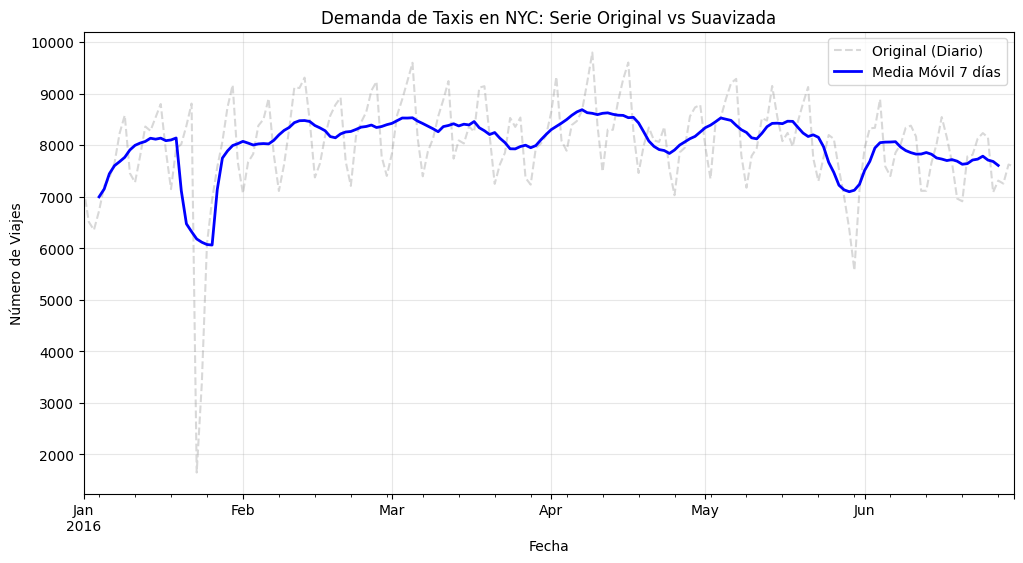

In [23]:
import matplotlib.pyplot as plt

#media móvil de 7 días
viajes_por_dia_smooth = viajes_por_dia.rolling(window=7, center=True).mean() #center=True para que el promedio se sitúe en medio de la semana

plt.figure(figsize=(12, 6)) #Graficar
viajes_por_dia.plot(alpha=0.3, label='Original (Diario)', color='gray', linestyle='--') # Serie Original
viajes_por_dia_smooth.plot(alpha=1, label='Media Móvil 7 días', color='blue', linewidth=2) # Serie Suavizada

plt.title('Demanda de Taxis en NYC: Serie Original vs Suavizada')
plt.xlabel('Fecha')
plt.ylabel('Número de Viajes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**18. Concepto: Visualización de Relaciones (Scatter con alpha)**

* **Teoría:** Con tantos datos, un scatter plot normal es una mancha sólida. El parámetro `alpha` es vital.
* **Reto:** Haz un Scatter Plot de `distance_km` vs `trip_duration`. Usa `alpha=0.1` para ver la densidad de puntos. ¿Ves líneas horizontales extrañas? (Son tarifas fijas o errores).

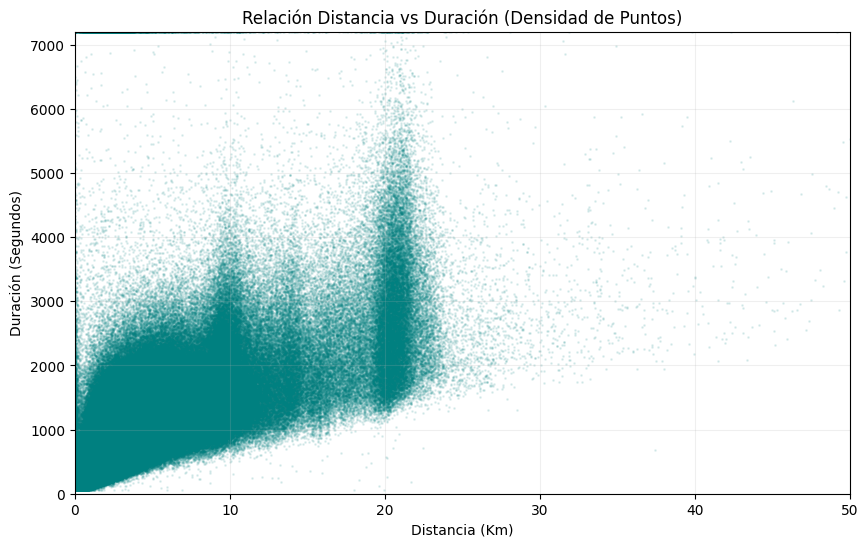

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    df['distance_km'], 
    df['trip_duration'], 
    alpha=0.1,      # 10% de opacidad: 10 puntos encima crean un color sólido
    s=1,            # Tamaño de punto muy pequeño para evitar solapamiento masivo
    c='teal'
)

plt.xlim(0, 50)     #viajes de hasta 50km
plt.ylim(0, 7200)   #viajes de hasta 2 horas

plt.title('Relación Distancia vs Duración (Densidad de Puntos)')
plt.xlabel('Distancia (Km)')
plt.ylabel('Duración (Segundos)')
plt.grid(True, alpha=0.2)
plt.show()

**19. Concepto: Heatmaps de Correlación**

* **Teoría:** Entender qué variables se mueven juntas.
* **Reto:** Crea una matriz de correlación (`df.corr()`) de las variables numéricas y visualízala con un Heatmap de Seaborn. ¿La cantidad de pasajeros influye en la duración del viaje?

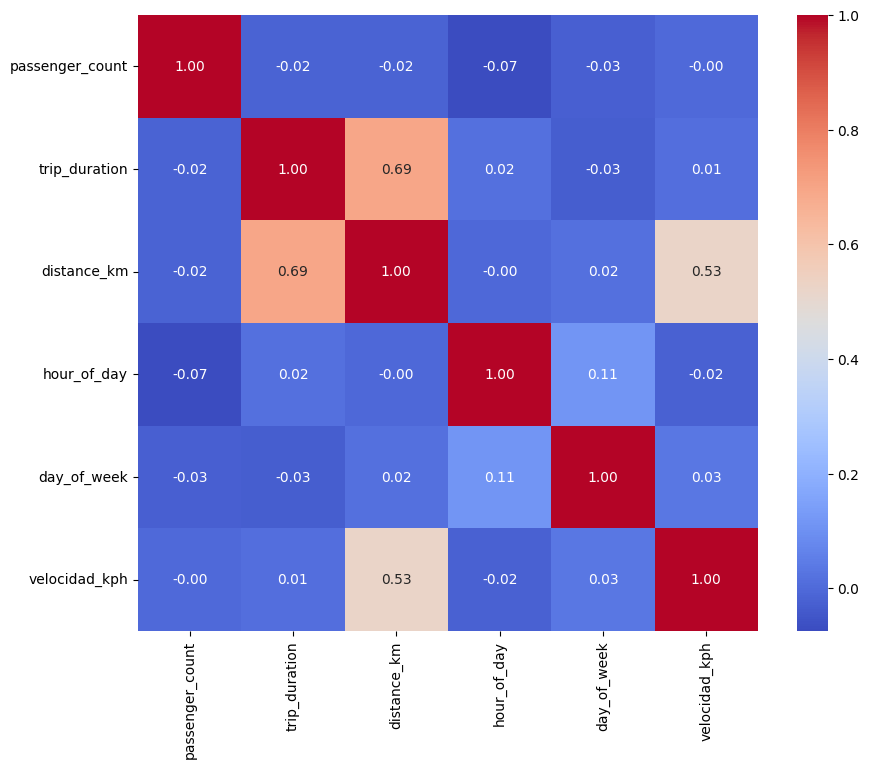

In [25]:
cols_interes = ['passenger_count', 'trip_duration', 'distance_km', 
                'hour_of_day', 'day_of_week', 'velocidad_kph']
matriz_corr = df_final_analisis[cols_interes].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

**20. Concepto: Exportación Eficiente (`to_parquet`)**

* **Teoría:** CSV es lento y pesado. Parquet mantiene los tipos de datos y comprime.
* **Reto:** Guarda tu DataFrame final limpio como `clean_taxi.parquet`. Compara el tamaño del archivo resultante contra el CSV original.
 

In [26]:
import os

df_final_analisis.to_parquet('clean_taxi.parquet') #Parquet
df_final_analisis.to_csv('clean_taxi.csv', index=False) #CSV

#Comparar tamaños en MB
size_parquet = os.path.getsize('clean_taxi.parquet') / (1024**2)
size_csv = os.path.getsize('clean_taxi.csv') / (1024**2)

print(f" Tamaño del CSV: {size_csv:.2f} MB")
print(f" Tamaño del Parquet: {size_parquet:.2f} MB")
print(f" ¡Reducción de espacio: {((1 - size_parquet/size_csv)*100):.2f}%!")

 Tamaño del CSV: 16.24 MB
 Tamaño del Parquet: 7.59 MB
 ¡Reducción de espacio: 53.25%!


### Parte B: Reto Visualización

In [57]:
from fpdf import FPDF
sns.set_theme(style="white")
plt.rcParams["figure.dpi"] = 500


In [58]:
# ----------------------------------
# FILTROS Y CLIPPING GLOBAL
# ----------------------------------

# 1) Clip de trip_duration: 1 min – 2 horas
df["trip_duration"] = df["trip_duration"].clip(lower=60, upper=7200)

# 2) Filtrar viajes con al menos 1 pasajero
df = df[df["passenger_count"] >= 1]


In [59]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

df["hour_of_day"] = df["pickup_datetime"].dt.hour
df["day_of_week"] = df["pickup_datetime"].dt.day_name()

orden_dias = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

df["day_of_week"] = pd.Categorical(
    df["day_of_week"],
    categories=orden_dias,
    ordered=True
)


In [60]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


df["distance_km"] = haversine(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"]
)

df["trip_hours"] = df["trip_duration"] / 3600
df["velocidad_kph"] = df["distance_km"] / df["trip_hours"]

# Limpieza básica
df = df[
    (df["velocidad_kph"] > 1) &
    (df["velocidad_kph"] < 120)
]


In [61]:
ASSETS_DIR = Path("assets")
ASSETS_DIR.mkdir(exist_ok=True)

In [63]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(
    df["trip_duration"] / 60,
    bins=80,
    color="#F4A261",      # naranja
    edgecolor="black"
)

ax.set_title(
    "En escala lineal, la duración de los viajes se concentra en valores bajos",
    fontsize=13
)
ax.set_xlabel("Duración del viaje (minutos)")
ax.set_ylabel("Frecuencia")

ax.grid(axis="y", alpha=0.3)
sns.despine()
plt.tight_layout()

ruta_g0 = ASSETS_DIR / "00_trip_duration_raw.png"
plt.savefig(ruta_g0, dpi=300)
plt.close()


In [64]:
# Hora pico: mañana y tarde
peak_hours = df[
    (df["hour_of_day"].between(7, 9)) |
    (df["hour_of_day"].between(17, 19))
]

p80_peak = peak_hours["trip_duration"].quantile(0.80) / 60

fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(
    df["trip_duration"] / 60,
    bins=50,
    color="#2A9D8F",      # verde
    edgecolor="black"
)

ax.set_xscale("log")

ax.set_title(
    "La duración de los viajes presenta una cola larga",
    fontsize=13
)
ax.set_xlabel("Duración del viaje (minutos, escala log)")
ax.set_ylabel("Frecuencia")

# Insight visual
ax.axvline(
    p80_peak,
    color="#E76F51",
    linestyle="--",
    linewidth=2
)

ax.annotate(
    f"80% de los viajes en hora pico\n< {p80_peak:.1f} minutos",
    xy=(p80_peak, ax.get_ylim()[1] * 0.5),
    xytext=(p80_peak * 1.4, ax.get_ylim()[1] * 0.8),
    arrowprops=dict(arrowstyle="->"),
    fontsize=10
)

ax.grid(axis="y", alpha=0.3)
sns.despine()
plt.tight_layout()

ruta_g1 = ASSETS_DIR / "01_trip_duration_log.png"
plt.savefig(ruta_g1, dpi=300)
plt.close()


In [66]:
lat_med = df["pickup_latitude"].median()
lon_med = df["pickup_longitude"].median()

fig, ax = plt.subplots(figsize=(7, 7))

hb = ax.hexbin(
    df["pickup_longitude"],
    df["pickup_latitude"],
    gridsize=60,
    cmap="YlOrRd",
    mincnt=1
)

ax.set_title(
    "La demanda de viajes se concentra en el eje central de Manhattan",
    fontsize=13
)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

ax.scatter(lon_med, lat_med, color="black", s=50)
ax.annotate(
    f"Centro de densidad\n({lat_med:.3f}, {lon_med:.3f})",
    xy=(lon_med, lat_med),
    xytext=(lon_med + 0.02, lat_med + 0.02),
    arrowprops=dict(arrowstyle="->"),
    fontsize=10
)

cb = fig.colorbar(hb, ax=ax)
cb.set_label("Cantidad de viajes")

sns.despine()
plt.tight_layout()

ruta_g2 = ASSETS_DIR / "02_hexbin_pickups.png"
plt.savefig(ruta_g2, dpi=300)
plt.close()


In [67]:
pivot = (
    df
    .groupby(["day_of_week", "hour_of_day"])["trip_duration"]
    .median()
    .unstack()
) / 60

hora_mas_lenta = pivot.mean(axis=0).idxmax()

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    pivot,
    cmap="YlGn",
    ax=ax
)

ax.set_title(
    "El tráfico urbano sigue un patrón temporal consistente",
    fontsize=13
)
ax.set_xlabel("Hora del día")
ax.set_ylabel("Día de la semana")

ax.annotate(
    f"Mayor duración\nalrededor de las {hora_mas_lenta}:00",
    xy=(hora_mas_lenta + 0.5, 0.5),
    xytext=(hora_mas_lenta + 2, 1.2),
    arrowprops=dict(arrowstyle="->"),
    fontsize=10
)

plt.tight_layout()
ruta_g3 = ASSETS_DIR / "03_heatmap_temporal.png"
plt.savefig(ruta_g3, dpi=300)
plt.close()


/tmp/ipykernel_39/2045889880.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["day_of_week", "hour_of_day"])["trip_duration"]


In [71]:
def classify_time_period(hour):
    if 7 <= hour <= 9:
        return "Pico Mañana"
    elif 17 <= hour <= 19:
        return "Pico Tarde"
    else:
        return "Hora Valle"

df["time_period"] = df["hour_of_day"].apply(classify_time_period)

orden_franjas = ["Pico Mañana", "Pico Tarde", "Hora Valle"]
df["time_period"] = pd.Categorical(
    df["time_period"],
    categories=orden_franjas,
    ordered=True
)


In [73]:
medianas = (
    df
    .groupby("time_period")["trip_duration"]
    .median()
) / 60

fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(
    data=df,
    x="time_period",
    y=df["trip_duration"] / 60,
    palette=["#E9C46A", "#F4A261", "#90BE6D"],
    showfliers=True,
    ax=ax
)

ax.set_title(
    "La congestión es más variable durante la hora pico de la tarde",
    fontsize=13
)
ax.set_xlabel("Franja horaria")
ax.set_ylabel("Duración del viaje (minutos)")

for i, (periodo, mediana) in enumerate(medianas.items()):
    ax.text(
        i,
        mediana + 1,
        f"Mediana:\n{mediana:.1f} min",
        ha="center",
        fontsize=10
    )

ax.grid(axis="y", alpha=0.3)
sns.despine()
plt.tight_layout()

ruta_g4 = ASSETS_DIR / "04_trip_duration_time_period.png"
plt.savefig(ruta_g4, dpi=300)
plt.close()


/tmp/ipykernel_39/3303805032.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("time_period")["trip_duration"]
/tmp/ipykernel_39/3303805032.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


In [86]:
# PROBABILIDAD DE VIAJES LARGOS POR FRANJA HORARIA
# Filtrar viajes con al menos 1 pasajero
df = df[df["passenger_count"] >= 1].copy()

# Limitar duraciones absurdas (1 min a 2 horas)
df["trip_duration"] = df["trip_duration"].clip(lower=60, upper=7200)


# CREAR FRANJA HORARIA


df["hour"] = df["pickup_datetime"].dt.hour

df["time_period"] = np.select(
    [
        df["hour"].between(7, 9),
        df["hour"].between(17, 19)
    ],
    [
        "Hora Pico Mañana",
        "Hora Pico Tarde"
    ],
    default="Hora Valle"
)



long_trip_threshold = df["trip_duration"].quantile(0.75) # 3. DEFINIR VIAJE LARGO (P75)

df["is_long_trip"] = (df["trip_duration"] > long_trip_threshold).astype(int)


prob_long = (
    df
    .groupby("time_period")["is_long_trip"]
    .mean()
)

# Ordenar de mayor a menor (orden visual correcto)
prob_long_sorted = prob_long.sort_values(ascending=False)

# Métricas clave para el insight
p_max = prob_long_sorted.iloc[0]
label_max = prob_long_sorted.index[0]

p_min = prob_long_sorted.iloc[-1]
label_min = prob_long_sorted.index[-1]

delta_max_vs_min = p_max - p_min


# GRÁFICO
sns.set_style("white")

fig, ax = plt.subplots(figsize=(8, 5))

colors = ["#fc8d62", "#ffd92f", "#66c2a5"]  # naranja → amarillo → verde

bars = ax.bar(
    prob_long_sorted.index,
    prob_long_sorted.values,
    color=colors[:len(prob_long_sorted)]
)

ax.set_ylim(0, prob_long_sorted.max() * 1.25)
ax.set_ylabel("Probabilidad de viaje largo")
ax.set_xlabel("Franja horaria")

ax.set_title(
    "La congestión no cambia el viaje típico,\npero sí aumenta el riesgo de viajes largos",
    fontsize=13,
    weight="bold"
)

# Etiquetas de porcentaje
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1%}",
        ha="center",
        va="bottom",
        fontsize=10,
        weight="bold"
    )

# Anotación del insight principal
ax.annotate(
    f"{label_max} presenta un riesgo\n{delta_max_vs_min:.1%} mayor que {label_min}",
    xy=(0, p_max),
    xytext=(0.6, p_max * 1.15),
    arrowprops=dict(arrowstyle="->"),
    fontsize=10
)

sns.despine()
plt.tight_layout()
plt.savefig("probabilidad_viajes_largos_ordenado.png", dpi=300)
plt.close()



In [103]:
from fpdf import FPDF

# ============================================================
# TEXTOS
# ============================================================

titulo_principal = "La dinámica del transporte en Nueva York"

intro_text = (
    "En Nueva York, los viajes diarios generan patrones complejos en términos "
    "de duración, demanda espacial y congestión.\n\n"
    "Este análisis busca comprender cómo se distribuyen los viajes y "
    "dónde se concentra la demanda, utilizando visualizaciones estadísticas."
)

text_duracion = (
    "La distribución de la duración de los viajes es altamente asimétrica. "
    "La mayoría de los trayectos son cortos, mientras que una fracción reducida "
    "alcanza duraciones significativamente mayores."
)

text_log = (
    "La escala logarítmica permite observar con mayor claridad la variabilidad "
    "real de los viajes y reduce la influencia de valores extremos."
)

text_mapa = (
    "El mapa de densidad muestra una fuerte concentración de viajes en el núcleo "
    "de la ciudad, particularmente en Midtown Manhattan, cerca de la Sexta Avenida "
    "y la Calle 42 Oeste."
)

text_heatmap = (
    "El patrón temporal evidencia diferencias claras entre días laborales y fines "
    "de semana. Durante los días hábiles, la demanda se intensifica, mientras que "
    "los fines de semana presentan una distribución más homogénea."
)

text_probabilidad = (
    f"{label_max} presenta la mayor probabilidad de viajes largos ({p_max:.1%}), "
    f"mientras que {label_min} muestra el menor riesgo ({p_min:.1%}). "
    f"La diferencia de {delta_max_vs_min:.1%} indica que la congestión no altera "
    f"el viaje típico, pero sí incrementa el riesgo de trayectos prolongados."
)

conclusion_text = (
    "El análisis confirma que la congestión urbana no se refleja en el viaje promedio, "
    "sino en el aumento del riesgo de viajes largos. Este enfoque probabilístico "
    "permite una comprensión más precisa del comportamiento del sistema de transporte."
)

# ============================================================
# PDF SETUP
# ============================================================

pdf = FPDF()
pdf.set_auto_page_break(auto=False)

def card_3d(x, y, w, h):
    pdf.set_fill_color(220, 220, 220)
    pdf.rect(x + 2, y + 2, w, h, style="F")
    pdf.set_fill_color(245, 245, 245)
    pdf.rect(x, y, w, h, style="F")

# ============================================================
# PÁGINA 1 – DISTRIBUCIONES
# ============================================================

pdf.add_page()

pdf.set_font("Times", "B", 16)
pdf.set_xy(10, 10)
pdf.cell(0, 10, titulo_principal)

pdf.set_font("Times", size=11)
pdf.set_xy(10, 22)
pdf.multi_cell(190, 6, intro_text)

card_3d(10, 45, 190, 85)

pdf.set_font("Times", "B", 12)
pdf.set_xy(15, 48)
pdf.cell(0, 6, "Distribución de la duración de los viajes")

pdf.image(ruta_g0, x=20, y=58, w=70)
pdf.image(ruta_g1, x=110, y=58, w=70)

card_3d(10, 135, 190, 45)
pdf.set_font("Times", size=11)
pdf.set_xy(15, 140)
pdf.multi_cell(180, 6, f"{text_duracion}\n\n{text_log}")

# ============================================================
# PÁGINA 2 – ESPACIAL Y TEMPORAL
# ============================================================

pdf.add_page()

# MAPA
card_3d(10, 10, 190, 70)

pdf.set_font("Times", "B", 13)
pdf.set_xy(15, 13)
pdf.cell(0, 6, "Concentración espacial de la demanda")

pdf.image(ruta_g2, x=10, y=20, w=60)

pdf.set_font("Times", size=11)
pdf.set_xy(100, 28)
pdf.multi_cell(80, 6, text_mapa)

# HEATMAP
card_3d(10, 85, 190, 70)

pdf.set_font("Times", "B", 13)
pdf.set_xy(15, 88)
pdf.cell(0, 6, "Patrones temporales de demanda")

pdf.image(ruta_g3, x=15, y=100, w=80)

pdf.set_font("Times", size=11)
pdf.set_xy(105, 103)
pdf.multi_cell(85, 6, text_heatmap)

# ============================================================
# PÁGINA 3 – PROBABILIDAD Y CONCLUSIÓN
# ============================================================

pdf.add_page()

card_3d(10, 10, 190, 85)

pdf.set_font("Times", "B", 13)
pdf.set_xy(15, 13)
pdf.multi_cell(
    0, 6,
    "La congestión no cambia el viaje típico,\npero sí aumenta el riesgo de viajes largos"
)

pdf.image("probabilidad_viajes_largos_ordenado.png", x=15, y=30, w=80)

pdf.set_font("Times", size=11)
pdf.set_xy(105, 30)
pdf.multi_cell(85, 6, text_probabilidad)

card_3d(10, 100, 190, 55)

pdf.set_font("Times", "B", 13)
pdf.set_xy(15, 103)
pdf.cell(0, 6, "Conclusiones")

pdf.set_font("Times", size=11)
pdf.set_xy(15, 112)
pdf.multi_cell(180, 6, conclusion_text)

# ============================================================
# GUARDAR
# ============================================================

pdf.output("reporte_storytelling_taxis_ny.pdf")
